In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm

tqdm.pandas()
pd.options.display.max_colwidth = None
sns.set_style('darkgrid')

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dtrain = pd.read_csv('../input/quora-question-pairs/train.csv.zip')
print(dtrain.shape)
dtrain.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [3]:
dtest = pd.read_csv('../input/quora-question-pairs/test.csv')
print(dtest.shape)
dtest.head()

(2345796, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,2,What but is the best way to send money from China to the US?,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Text Cleaning

In [4]:
%%time

all_ques = pd.read_csv('../input/qqp-cleaned/quora-ques-pair-all-ques.csv')
all_ques.head()

CPU times: user 9.05 s, sys: 919 ms, total: 9.96 s
Wall time: 12.8 s


,RawText,CleanedText
0,What is the step by step guide to invest in share market in india?,step step guide invest share market india
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,story kohinoor koh noor diamond
2,How can I increase the speed of my internet connection while using a VPN?,increase speed internet connection vpn
3,Why am I mentally very lonely? How can I solve it?,mentally lonely solve
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",dissolve water quikly sugar salt methane carbon di oxide


In [5]:
%%time

text_map = {x:y for x, y in zip(all_ques['RawText'].values, all_ques['CleanedText'].values)}

dtrain['question1'] = dtrain['question1'].apply(lambda x: text_map[x])
dtrain['question2'] = dtrain['question2'].apply(lambda x: text_map[x])

dtest['question1'] = dtest['question1'].apply(lambda x: text_map[x])
dtest['question2'] = dtest['question2'].apply(lambda x: text_map[x])

del text_map

CPU times: user 7.32 s, sys: 225 ms, total: 7.55 s
Wall time: 7.55 s


# Cross Validation

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=19)
train_index, valid_index = list(sss.split(dtrain[['question1', 'question2']].values, dtrain['is_duplicate']))[0]

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, x_train, x_valid, y_train, y_valid):
    print('Train Set:')
    print()
    print(classification_report(y_train, model.predict(x_train)))
    
    print()
    print()
    
    print('Validation Set:')
    print()
    print(classification_report(y_valid, model.predict(x_valid)))

# Vectorization

In [8]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=1,
    max_df=1.0,
    sublinear_tf=True
).fit(all_ques['CleanedText'].fillna('').values)

x_train = dtrain[['question1', 'question2']].iloc[train_index].reset_index(drop=True)
x_valid = dtrain[['question1', 'question2']].iloc[valid_index].reset_index(drop=True)

y_train = dtrain['is_duplicate'].iloc[train_index].reset_index(drop=True).values
y_valid = dtrain['is_duplicate'].iloc[valid_index].reset_index(drop=True).values

del all_ques

y_train.shape, y_valid.shape

CPU times: user 52.2 s, sys: 844 ms, total: 53 s
Wall time: 53.2 s


((400247,), (4043,))

In [9]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [10]:
%%time

from scipy import sparse

x_train_1 = vectorizer.transform(x_train['question1'].fillna(''))
x_train_2 = vectorizer.transform(x_train['question2'].fillna(''))

x_valid_1 = vectorizer.transform(x_valid['question1'].fillna(''))
x_valid_2 = vectorizer.transform(x_valid['question2'].fillna(''))

x_test_1 = vectorizer.transform(dtest['question1'].fillna(''))
x_test_2 = vectorizer.transform(dtest['question2'].fillna(''))

x_train = [sparse_tensor(x_train_1), sparse_tensor(x_train_2)]
x_valid = [sparse_tensor(x_valid_1), sparse_tensor(x_valid_2)]
x_test = [sparse_tensor(x_test_1), sparse_tensor(x_test_2)]

x = [
    sparse_tensor(sparse.vstack([x_train_1, x_valid_1])), 
    sparse_tensor(sparse.vstack([x_train_2, x_valid_2]))
]
y = np.concatenate([y_train, y_valid])

del x_train_1, x_train_2, x_valid_1, x_valid_2, x_test_1, x_test_2

x_train[0].shape, x_valid[0].shape, x_test[0].shape

CPU times: user 1min 4s, sys: 2.23 s, total: 1min 6s
Wall time: 1min 8s


(TensorShape([400247, 102967]),
 TensorShape([4043, 102967]),
 TensorShape([2345796, 102967]))

# Modelling

In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers

In [12]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def cosine_similarity(vectors):
    (featsA, featsB) = vectors
    featsA = K.l2_normalize(featsA, axis=-1)
    featsB = K.l2_normalize(featsB, axis=-1)
    return K.mean(featsA * featsB, axis=-1, keepdims=True)

In [13]:
class SiameseNetwork(Model):
    def __init__(self, inputShape, featExtractorConfig):
        super(SiameseNetwork, self).__init__()
        
        inpA = layers.Input(shape=inputShape)
        inpB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, featExtractorConfig)
        featsA = featureExtractor(inpA)
        featsB = featureExtractor(inpB)
        distance = layers.Concatenate()([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[inpA, inpB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, featExtractorConfig):
        
        layers_config = [layers.Input(inputShape)]
        for i, n_units in enumerate(featExtractorConfig):
            layers_config.append(layers.Dense(n_units))
            layers_config.append(layers.Dropout(0.5))
            layers_config.append(layers.BatchNormalization())
            layers_config.append(layers.Activation('relu'))
        
        model = Sequential(layers_config, name='feature_extractor')

        return model  
        
    def call(self, x):
        return self.model(x)

model = SiameseNetwork(inputShape=x_train[0].shape[1], featExtractorConfig=[100])
model.compile(
    loss="binary_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10296800  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
Total params: 10,297,200
Trainable params: 10,297,000
Non-trainable params: 200
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)

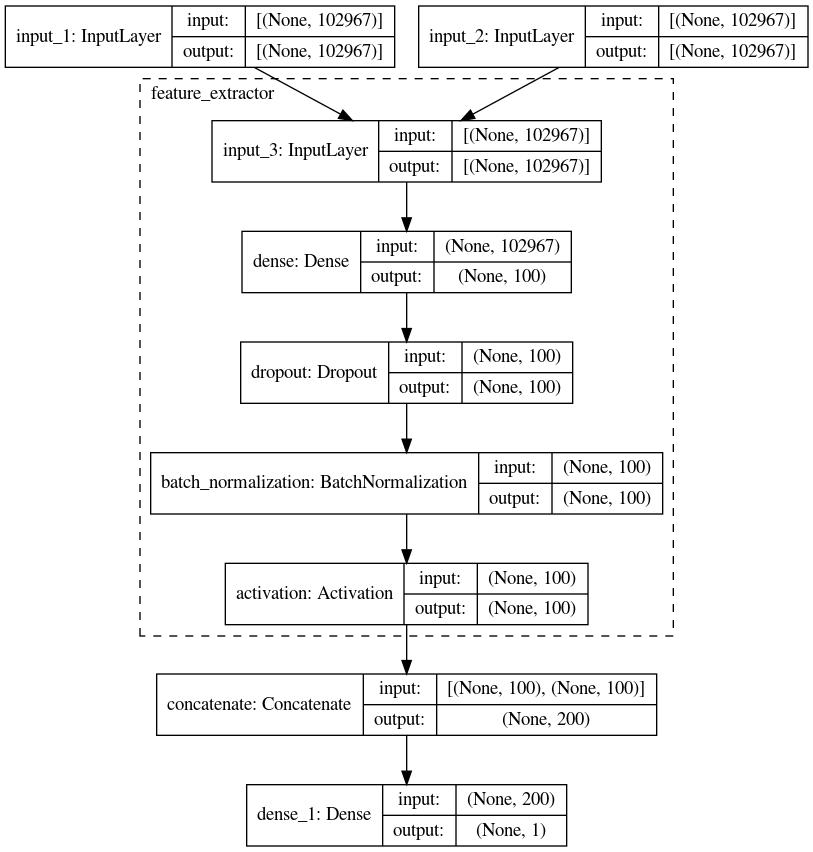

In [14]:
model.model.layers[2].summary()
model.model.summary()
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

In [15]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, min_lr=1e-10, mode='min', verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=32, 
    epochs=100,
    callbacks=[es, rlp]
)

Epoch 1/100
12508/12508 [==============================] - 82s 6ms/step - loss: 0.5586 - accuracy: 0.7233 - val_loss: 0.5181 - val_accuracy: 0.7504
Epoch 2/100
12508/12508 [==============================] - 78s 6ms/step - loss: 0.4802 - accuracy: 0.7730 - val_loss: 0.5016 - val_accuracy: 0.7591
Epoch 3/100
12508/12508 [==============================] - 78s 6ms/step - loss: 0.4522 - accuracy: 0.7892 - val_loss: 0.4996 - val_accuracy: 0.7608
Epoch 4/100
12508/12508 [==============================] - 79s 6ms/step - loss: 0.4350 - accuracy: 0.7988 - val_loss: 0.4946 - val_accuracy: 0.7638
Epoch 5/100
12508/12508 [==============================] - 78s 6ms/step - loss: 0.4181 - accuracy: 0.8088 - val_loss: 0.4919 - val_accuracy: 0.7727
Epoch 6/100
12508/12508 [==============================] - 77s 6ms/step - loss: 0.4053 - accuracy: 0.8152 - val_loss: 0.4902 - val_accuracy: 0.7685
Epoch 7/100
12508/12508 [==============================] - 78s 6ms/step - loss: 0.3922 - accuracy: 0.8224 - val_

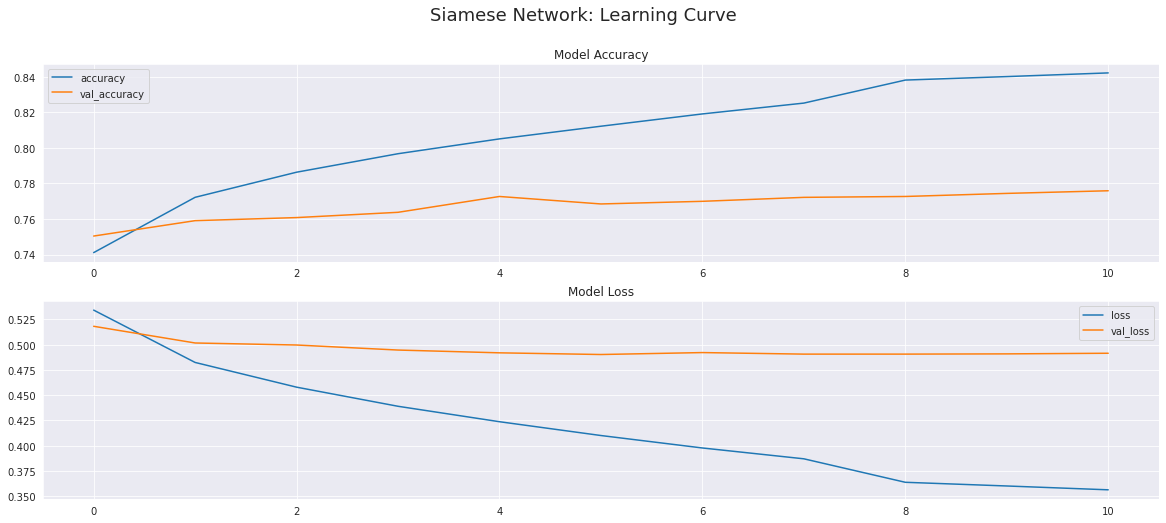

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Siamese Network: Learning Curve', fontsize=18);

In [17]:
%%time

submission = pd.DataFrame({
    'test_id': dtest.test_id.values,
    'is_duplicate': np.ravel(model.predict(x_test, batch_size=32))
})
submission.to_csv('submission.csv', index=False)

CPU times: user 3min 6s, sys: 22.1 s, total: 3min 28s
Wall time: 2min 29s
